<a href="https://colab.research.google.com/github/merovivant/AssistenteVestibular/blob/main/Notebooks/retrievers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retrievers
Este documento visa utilizar o dataset de validação para avaliar o desempenho de diferentes módulos retrievers do langchain na construção da resposta final.

In [1]:
!pip -q install openai langchain pinecone-client tiktoken rapidfuzz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.4/179.4 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.4/300.4 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.


In [2]:
# Importando o dataset de validação
import pandas as pd
from google.colab import drive
drive.mount("/drive")

validacao = pd.read_csv("/drive/MyDrive/Chatbot/validacao.csv", dtype=str)

Mounted at /drive


## Criando o template do prompt

In [3]:
from langchain.prompts import PromptTemplate
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

template = """Você é um chatbot tendo uma conversa com um humano.
Dado as seguintes partes extraídas da resolução do vestibular da Unicamp, crie uma resposta final concisa e direta com o que foi perguntado.
Se não for possível responder pelo contexto, diga que não possui a resposta.

{context}

Human: {human_input}
Chatbot:"""
prompt = PromptTemplate(
    input_variables=["human_input", "context"], template=template
)
chain = load_qa_chain(
    OpenAI(temperature=0), chain_type="stuff", prompt=prompt, verbose=True
)

OpenAI API Key:··········


## Pinecone Retriever

In [4]:
import pinecone
from langchain.vectorstores import Pinecone
from langchain.embeddings.openai import OpenAIEmbeddings

# Importando as chaves de API necessárias
os.environ["PINECONE_API_KEY"] = getpass.getpass("Pinecone API Key:")
os.environ["PINECONE_ENV"] = getpass.getpass("Pinecone Environment:")

embeddings = OpenAIEmbeddings(openai_api_key=os.getenv("OPENAI_API_KEY"))

#Inicializando o Pinecone
pinecone.init(
    api_key=os.getenv("PINECONE_API_KEY"),
    environment=os.getenv("PINECONE_ENV"),
)

retriever = Pinecone.from_existing_index("unicampresolucao", embeddings).as_retriever()

/usr/local/lib/python3.10/dist-packages/pinecone/index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Pinecone API Key:··········
Pinecone Environment:··········


## CompressionRetriever

In [5]:
from langchain.chat_models import ChatOpenAI
from langchain.document_transformers import EmbeddingsRedundantFilter
from langchain.retrievers.document_compressors import DocumentCompressorPipeline, EmbeddingsFilter
from langchain.retrievers import ContextualCompressionRetriever
from langchain.text_splitter import CharacterTextSplitter

#Compressão dos documentos para filtrar partes relevantes
splitter = CharacterTextSplitter(chunk_size=300, chunk_overlap=120, separator=". ") #Divide os documentos encontrados em partes menores
redundant_filter = EmbeddingsRedundantFilter(embeddings=embeddings) #Filtra documentos redundantes
relevant_filter = EmbeddingsFilter(embeddings=embeddings, similarity_threshold=0.76) #Filtra somente documentos relevantes pra consulta com base no limite de decisão
pipeline_compressor = DocumentCompressorPipeline(
    transformers=[splitter, redundant_filter, relevant_filter]
)

compression_retriever = ContextualCompressionRetriever(base_compressor=pipeline_compressor, base_retriever=retriever)

## MultyQueryRetriever

In [6]:
from langchain.retrievers.multi_query import MultiQueryRetriever

llm = ChatOpenAI(temperature=0)
retriever_from_llm = MultiQueryRetriever.from_llm(
    retriever=retriever, llm=llm
)

# Set logging for the queries
import logging

logging.basicConfig()
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

#unique_docs = retriever_from_llm.get_relevant_documents(query=question)

## Consultando documentos

Utilizando os retrievers para acessar os documentos relevantes e armazenando-os para eventual geração de resposta

In [ ]:
import time

pinecone_docs = []
compression_docs = []
multyquery_docs = []

for i in range(21):
  #Para cada query dos dados de validação é criada uma consulta utilizando os diferentes retrievers
  query = validacao.loc[i, "query"]

  doc1 = retriever.get_relevant_documents(query, top_k=10)
  doc1 = "\n\n".join([d.page_content for d in doc1])
  pinecone_docs.append(doc1)
  time.sleep(30)

  doc2 = compression_retriever.get_relevant_documents(query, top_k=10)
  doc2 = "\n\n".join([d.page_content for d in doc2])
  compression_docs.append(doc2)
  time.sleep(30)

  doc3 = retriever_from_llm.get_relevant_documents(query, top_k=10)
  doc3 = "\n\n".join([d.page_content for d in doc3])
  multyquery_docs.append(doc3)
  time.sleep(30)

#Os documentos encontrados são armazenados e exportados pra um arquivo csv
documents = pd.DataFrame([pinecone_docs,compression_docs,multyquery_docs])
documents.to_csv("/drive/MyDrive/Chatbot/docs.csv", index=False)

In [13]:
documents = pd.read_csv("/drive/MyDrive/Chatbot/docs.csv", dtype=str)
documents = documents.T
documents.columns = ["pinecone","compression","multyquery"]

## Gerando respostas com base nos documentos recuperados

In [31]:
import time

answer1 = []
answer2 = []
answer3 = []
for i in range(13):
  #Para cada conjunto de documento recuperado vai ser gerada uma resposta diferente
  query = validacao.loc[i, "query"]

  docs1 = documents["pinecone"][i]
  docs2 = documents["compression"][i]
  docs3 = documents["multyquery"][i]

  response1 = chain({"input_documents": text_to_docs(docs1), "human_input": query})
  answer1.append(response1['output_text'])
  time.sleep(15)

  response2 = chain({"input_documents": text_to_docs(docs2), "human_input": query})
  answer2.append(response2['output_text'])
  time.sleep(15)

  response3 = chain({"input_documents": text_to_docs(docs3), "human_input": query})
  answer3.append(response3['output_text'])
  time.sleep(15)



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Você é um chatbot tendo uma conversa com um humano.
Dado as seguintes partes extraídas da resolução do vestibular da Unicamp, crie uma resposta final concisa e direta com o que foi perguntado.
Se não for possível responder pelo contexto, diga que não possui a resposta.

Cursos de graduação por área de realização da prova do Vestibular Unicamp.

A partir da lista de obras apresentadas a cada ano pelo Vestibular Unicamp, espera-se que o candidato seja capaz de mobilizar um conjunto de conhecimentos apreendidos ao longo do ensino médio a fim de desenvolver as habilidades próprias da leitura literária. Esses conhecimentos podem ser expressos por meio de alguns conceitos fundamentais que dizem respeito aos elementos que constituem uma obra

Para todas as opções a Prova de Habilidades Específicas terá peso 3 (três), conforme Resolução do Vestibular Unicamp 2024
A nota da primeira fase se



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Você é um chatbot tendo uma conversa com um humano.
Dado as seguintes partes extraídas da resolução do vestibular da Unicamp, crie uma resposta final concisa e direta com o que foi perguntado.
Se não for possível responder pelo contexto, diga que não possui a resposta.

Cursos de graduação por área de realização da prova do Vestibular Unicamp.

III. 325 vagas oferecidas pelo Provão Paulista 2024.
IV. 49 vagas oferecidas pelo Vestibular Indígena (VI) 2024. O Vestibular Indígena terá ainda 81 vagas adicionais, conforme Edital a ser publicado, respeitando os princípios da Deliberação CONSU-A-032/2017.

As provas de Habilidades Específicas para o curso de Artes Visuais serão realizadas somente em Campinas, de 07 a 09 de dezembro de 2023.  
Os horários serão divulgados na página eletrônica da Comvest (www.comvest.unicamp.br), a partir do dia 27/11/2023.

Human: A Unicamp terá provas dif



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Você é um chatbot tendo uma conversa com um humano.
Dado as seguintes partes extraídas da resolução do vestibular da Unicamp, crie uma resposta final concisa e direta com o que foi perguntado.
Se não for possível responder pelo contexto, diga que não possui a resposta.

§3º Em caso de dúvidas quanto à identificação ou à documentação do(a) candidato(a), a Unicamp poderá requerer laudos de especialistas, incluindo exames grafotécnicos sobre assinaturas, provas ou outros documentos considerados relevantes.

A matrícula dos(as) candidatos(as) convocados(as) para os cursos de graduação da Unicamp cabe exclusivamente à Diretoria Acadêmica – DAC, exigindo-se, neste ato, o upload dos documentos relacionados nos incisos deste artigo no Sistema de Gestão Acadêmica (SIGA).  
I. Para todos(as) os(as) candidatos(as):
a) Diploma ou Certificado de Conclusão do ensino médio ou equivalente.

Cursos



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Você é um chatbot tendo uma conversa com um humano.
Dado as seguintes partes extraídas da resolução do vestibular da Unicamp, crie uma resposta final concisa e direta com o que foi perguntado.
Se não for possível responder pelo contexto, diga que não possui a resposta.

§4º Disputarão as vagas pelo programa de reserva de vagas (cotas) apenas os(as) candidatos(as) autodeclarados(as) pretos(as) e pardos(as) que expressamente optarem pelo mesmo.  
§5º As vagas não preenchidas por reserva para autodeclarados(as) pretos(as) e pardos(as) serão ocupadas pelos(as) demais candidatos(as) inscritos(as).

Não poderão se beneficiar do PAAIS ou de reserva de vagas (cotas) para autodeclarados(as) pretos(as) e pardos(as) candidatos(as) que já tenham concluído curso de graduação ou pós-graduação em Instituições de Ensino Superior públicas brasileiras (municipais, estaduais ou federais).

Para ter d



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Você é um chatbot tendo uma conversa com um humano.
Dado as seguintes partes extraídas da resolução do vestibular da Unicamp, crie uma resposta final concisa e direta com o que foi perguntado.
Se não for possível responder pelo contexto, diga que não possui a resposta.

Não poderão se beneficiar do PAAIS ou de reserva de vagas (cotas) para autodeclarados(as) pretos(as) e pardos(as) candidatos(as) que já tenham concluído curso de graduação ou pós-graduação em Instituições de Ensino Superior públicas brasileiras (municipais, estaduais ou federais).

Para ter direito à ação afirmativa por critério étnico-racial, os(as) estudantes selecionados(as) que concorreram às vagas reservadas aos(às) autodeclarados(as) pretos(as) ou pardos(as) deverão possuir traços fenotípicos que os(as) caracterizem como negro(as), de cor preta ou parda.

§1º Os(as) candidatos(as) autodeclarados(as) pretos(as)



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Você é um chatbot tendo uma conversa com um humano.
Dado as seguintes partes extraídas da resolução do vestibular da Unicamp, crie uma resposta final concisa e direta com o que foi perguntado.
Se não for possível responder pelo contexto, diga que não possui a resposta.

Para ter direito à ação afirmativa por critério étnico-racial, os(as) estudantes selecionados(as) que concorreram às vagas reservadas aos(às) autodeclarados(as) pretos(as) ou pardos(as) deverão possuir traços fenotípicos que os(as) caracterizem como negro(as), de cor preta ou parda.

§4º Disputarão as vagas pelo programa de reserva de vagas (cotas) apenas os(as) candidatos(as) autodeclarados(as) pretos(as) e pardos(as) que expressamente optarem pelo mesmo.  
§5º As vagas não preenchidas por reserva para autodeclarados(as) pretos(as) e pardos(as) serão ocupadas pelos(as) demais candidatos(as) inscritos(as).

§11 O(a)



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Você é um chatbot tendo uma conversa com um humano.
Dado as seguintes partes extraídas da resolução do vestibular da Unicamp, crie uma resposta final concisa e direta com o que foi perguntado.
Se não for possível responder pelo contexto, diga que não possui a resposta.

Para ter direito à ação afirmativa por critério étnico-racial, os(as) estudantes selecionados(as) que concorreram às vagas reservadas aos(às) autodeclarados(as) pretos(as) ou pardos(as) deverão possuir traços fenotípicos que os(as) caracterizem como negro(as), de cor preta ou parda.

§11 O(a) candidato(a) que participar do PAAIS Ensino Médio e/ou das reservas de vagas (cotas) para autodeclarados(as) pretos(as) e pardos(as) de escola pública terá a possibilidade de optar pela inscrição automática para as vagas do Edital ENEM-Unicamp, referidas no inciso II do Artigo 1º, na área de inscrição do VU 2024, sendo desneces



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Você é um chatbot tendo uma conversa com um humano.
Dado as seguintes partes extraídas da resolução do vestibular da Unicamp, crie uma resposta final concisa e direta com o que foi perguntado.
Se não for possível responder pelo contexto, diga que não possui a resposta.

Para ter direito à ação afirmativa por critério étnico-racial, os(as) estudantes selecionados(as) que concorreram às vagas reservadas aos(às) autodeclarados(as) pretos(as) ou pardos(as) deverão possuir traços fenotípicos que os(as) caracterizem como negro(as), de cor preta ou parda.

§11 O(a) candidato(a) que participar do PAAIS Ensino Médio e/ou das reservas de vagas (cotas) para autodeclarados(as) pretos(as) e pardos(as) de escola pública terá a possibilidade de optar pela inscrição automática para as vagas do Edital ENEM-Unicamp, referidas no inciso II do Artigo 1º, na área de inscrição do VU 2024, sendo desneces



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Você é um chatbot tendo uma conversa com um humano.
Dado as seguintes partes extraídas da resolução do vestibular da Unicamp, crie uma resposta final concisa e direta com o que foi perguntado.
Se não for possível responder pelo contexto, diga que não possui a resposta.

Para o ano de 2024 são oferecidas 3340 vagas regulares para ingresso nos Cursos de Graduação da Unicamp distribuídas nos seguintes sistemas de ingresso:  
I. 2537 vagas oferecidas pelo Vestibular Unicamp (VU) 2024.
II. 314 vagas oferecidas pelo Edital ENEM-Unicamp 2024.
III. 325 vagas oferecidas pelo Provão Paulista 2024.

§3º Os(as) candidatos(as) contemplados(as) com a isenção da Taxa de Inscrição no Programa de Isenção de Pagamento da Taxa de Inscrição para o Ingresso Unicamp 2024 não estão automaticamente inscritos(as) no VU 2024 e devem fazer a inscrição na página da Comvest no período estipulado no artigo 13.




> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Você é um chatbot tendo uma conversa com um humano.
Dado as seguintes partes extraídas da resolução do vestibular da Unicamp, crie uma resposta final concisa e direta com o que foi perguntado.
Se não for possível responder pelo contexto, diga que não possui a resposta.

Para o ano de 2024 são oferecidas 3340 vagas regulares para ingresso nos Cursos de Graduação da Unicamp distribuídas nos seguintes sistemas de ingresso:  
I. 2537 vagas oferecidas pelo Vestibular Unicamp (VU) 2024.
II. 314 vagas oferecidas pelo Edital ENEM-Unicamp 2024.
III. 325 vagas oferecidas pelo Provão Paulista 2024.

O(a) candidato(a) que participar de mais de um dos sistemas de seleção previstos na Deliberação CONSU-A-032/2017 (Vestibular Unicamp, Edital ENEM-Unicamp, Vestibular Indígena, Edital “Vagas Olímpicas”) será excluído(a), automaticamente, das vagas em outros sistemas quando efetivar a sua matrícula 



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Você é um chatbot tendo uma conversa com um humano.
Dado as seguintes partes extraídas da resolução do vestibular da Unicamp, crie uma resposta final concisa e direta com o que foi perguntado.
Se não for possível responder pelo contexto, diga que não possui a resposta.

Os(as) candidatos(as) que tenham cursado o Ensino Fundamental II e/ou o Ensino Médio integralmente em escola pública brasileira poderão participar do Programa de Ação Afirmativa e Inclusão Social (PAAIS), recebendo a bonificação especificada na Deliberação CONSU-A-032/2017:

§2º A pontuação a ser adicionada é aquela referida no art. 9º.  
§3º Candidatos(as) que tenham cursado algum período do Ensino Fundamental II e/ou Ensino Médio em instituição privada na condição de bolsista não podem ser contemplados(as) com a bonificação do PAAIS no período correspondente.

Para optantes pelo PAAIS com uso de exames de certific



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Você é um chatbot tendo uma conversa com um humano.
Dado as seguintes partes extraídas da resolução do vestibular da Unicamp, crie uma resposta final concisa e direta com o que foi perguntado.
Se não for possível responder pelo contexto, diga que não possui a resposta.

a) Diploma ou Certificado de Conclusão do ensino médio ou equivalente.  
II. Para optantes pelo PAAIS- Ensino Fundamental II:
Para quem declarou ter cursado integralmente em escola pública brasileira o Ensino Fundamental II (da 5ª a 8ª série ou 6º ao 9º ano).

Os(as) candidatos(as) que tenham cursado o Ensino Fundamental II e/ou o Ensino Médio integralmente em escola pública brasileira poderão participar do Programa de Ação Afirmativa e Inclusão Social (PAAIS), recebendo a bonificação especificada na Deliberação CONSU-A-032/2017:

§1º A participação no PAAIS é facultativa e deverá ser indicada no Formulário de Inscr



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Você é um chatbot tendo uma conversa com um humano.
Dado as seguintes partes extraídas da resolução do vestibular da Unicamp, crie uma resposta final concisa e direta com o que foi perguntado.
Se não for possível responder pelo contexto, diga que não possui a resposta.

V. Para optantes pelo PAAIS com uso de exames de certificação:
a) Para quem possui Certificado de conclusão do Ensino Médio por meio do ENEM (até 2016);
b) Certificado de conclusão do ENCCEJA.
c) Certificado ou declaração de conclusão do Ensino Médio por meio do EJA, modalidade presencial, semipresencial ou a distância.

a) Diploma ou Certificado de Conclusão do ensino médio ou equivalente.  
II. Para optantes pelo PAAIS- Ensino Fundamental II:
Para quem declarou ter cursado integralmente em escola pública brasileira o Ensino Fundamental II (da 5ª a 8ª série ou 6º ao 9º ano).

a) Histórico Escolar Completo do Ensino



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Você é um chatbot tendo uma conversa com um humano.
Dado as seguintes partes extraídas da resolução do vestibular da Unicamp, crie uma resposta final concisa e direta com o que foi perguntado.
Se não for possível responder pelo contexto, diga que não possui a resposta.

V. Para optantes pelo PAAIS com uso de exames de certificação:
a) Para quem possui Certificado de conclusão do Ensino Médio por meio do ENEM (até 2016);
b) Certificado de conclusão do ENCCEJA.
c) Certificado ou declaração de conclusão do Ensino Médio por meio do EJA, modalidade presencial, semipresencial ou a distância.

a) Diploma ou Certificado de Conclusão do ensino médio ou equivalente.  
II. Para optantes pelo PAAIS- Ensino Fundamental II:
Para quem declarou ter cursado integralmente em escola pública brasileira o Ensino Fundamental II (da 5ª a 8ª série ou 6º ao 9º ano).

a) Histórico Escolar Completo do Ensino



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Você é um chatbot tendo uma conversa com um humano.
Dado as seguintes partes extraídas da resolução do vestibular da Unicamp, crie uma resposta final concisa e direta com o que foi perguntado.
Se não for possível responder pelo contexto, diga que não possui a resposta.

a)  Histórico Escolar Completo do Ensino Fundamental II realizado em estabelecimentos da rede pública brasileira (federal, estadual, municipal).  
III. Para optantes pelo PAAIS - Ensino Médio:
Para quem declarou ter cursado integralmente em escola pública brasileira o Ensino Médio (do 1º ao 3º ano).

Os(as) candidatos(as) que tenham cursado o Ensino Fundamental II e/ou o Ensino Médio integralmente em escola pública brasileira poderão participar do Programa de Ação Afirmativa e Inclusão Social (PAAIS), recebendo a bonificação especificada na Deliberação CONSU-A-032/2017:

a) Histórico Escolar Completo do Ensino Médio



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Você é um chatbot tendo uma conversa com um humano.
Dado as seguintes partes extraídas da resolução do vestibular da Unicamp, crie uma resposta final concisa e direta com o que foi perguntado.
Se não for possível responder pelo contexto, diga que não possui a resposta.

Os(as) candidatos(as) que tenham cursado o Ensino Fundamental II e/ou o Ensino Médio integralmente em escola pública brasileira poderão participar do Programa de Ação Afirmativa e Inclusão Social (PAAIS), recebendo a bonificação especificada na Deliberação CONSU-A-032/2017:

a) Diploma ou Certificado de Conclusão do ensino médio ou equivalente.  
II. Para optantes pelo PAAIS- Ensino Fundamental II:
Para quem declarou ter cursado integralmente em escola pública brasileira o Ensino Fundamental II (da 5ª a 8ª série ou 6º ao 9º ano).

a) Histórico Escolar Completo do Ensino Médio realizado em estabelecimentos da rede pú



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Você é um chatbot tendo uma conversa com um humano.
Dado as seguintes partes extraídas da resolução do vestibular da Unicamp, crie uma resposta final concisa e direta com o que foi perguntado.
Se não for possível responder pelo contexto, diga que não possui a resposta.

Os(as) candidatos(as) que tenham cursado o Ensino Fundamental II e/ou o Ensino Médio integralmente em escola pública brasileira poderão participar do Programa de Ação Afirmativa e Inclusão Social (PAAIS), recebendo a bonificação especificada na Deliberação CONSU-A-032/2017:

a) Diploma ou Certificado de Conclusão do ensino médio ou equivalente.  
II. Para optantes pelo PAAIS- Ensino Fundamental II:
Para quem declarou ter cursado integralmente em escola pública brasileira o Ensino Fundamental II (da 5ª a 8ª série ou 6º ao 9º ano).

§1º A participação no PAAIS é facultativa e deverá ser indicada no Formulário de Inscr



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Você é um chatbot tendo uma conversa com um humano.
Dado as seguintes partes extraídas da resolução do vestibular da Unicamp, crie uma resposta final concisa e direta com o que foi perguntado.
Se não for possível responder pelo contexto, diga que não possui a resposta.

Os(as) candidatos(as) que tenham cursado o Ensino Fundamental II e/ou o Ensino Médio integralmente em escola pública brasileira poderão participar do Programa de Ação Afirmativa e Inclusão Social (PAAIS), recebendo a bonificação especificada na Deliberação CONSU-A-032/2017:

a)  Histórico Escolar Completo do Ensino Fundamental II realizado em estabelecimentos da rede pública brasileira (federal, estadual, municipal).  
III. Para optantes pelo PAAIS - Ensino Médio:
Para quem declarou ter cursado integralmente em escola pública brasileira o Ensino Médio (do 1º ao 3º ano).

§2º A pontuação a ser adicionada é aquela ref



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Você é um chatbot tendo uma conversa com um humano.
Dado as seguintes partes extraídas da resolução do vestibular da Unicamp, crie uma resposta final concisa e direta com o que foi perguntado.
Se não for possível responder pelo contexto, diga que não possui a resposta.

a) Diploma ou Certificado de Conclusão do ensino médio ou equivalente.  
II. Para optantes pelo PAAIS- Ensino Fundamental II:
Para quem declarou ter cursado integralmente em escola pública brasileira o Ensino Fundamental II (da 5ª a 8ª série ou 6º ao 9º ano).

a)  Histórico Escolar Completo do Ensino Fundamental II realizado em estabelecimentos da rede pública brasileira (federal, estadual, municipal).  
III. Para optantes pelo PAAIS - Ensino Médio:
Para quem declarou ter cursado integralmente em escola pública brasileira o Ensino Médio (do 1º ao 3º ano).

a) Histórico Escolar Completo do Ensino Médio realizado em e



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Você é um chatbot tendo uma conversa com um humano.
Dado as seguintes partes extraídas da resolução do vestibular da Unicamp, crie uma resposta final concisa e direta com o que foi perguntado.
Se não for possível responder pelo contexto, diga que não possui a resposta.

§3º Os(as) candidatos(as) contemplados(as) com a isenção da Taxa de Inscrição no Programa de Isenção de Pagamento da Taxa de Inscrição para o Ingresso Unicamp 2024 não estão automaticamente inscritos(as) no VU 2024 e devem fazer a inscrição na página da Comvest no período estipulado no artigo 13.

Caso um(a) candidato(a) tenha sido convocado(a) em cursos diferentes, na mesma chamada, no VU 2024 e em outro(s) sistema(s) de ingresso, será considerada como opção a matrícula que ele(a) tenha efetivado primeiro, como gesto de sua deliberada escolha.

O ingresso nos Cursos de Graduação por meio do VU 2024 será feito media



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Você é um chatbot tendo uma conversa com um humano.
Dado as seguintes partes extraídas da resolução do vestibular da Unicamp, crie uma resposta final concisa e direta com o que foi perguntado.
Se não for possível responder pelo contexto, diga que não possui a resposta.

§3º Os(as) candidatos(as) contemplados(as) com a isenção da Taxa de Inscrição no Programa de Isenção de Pagamento da Taxa de Inscrição para o Ingresso Unicamp 2024 não estão automaticamente inscritos(as) no VU 2024 e devem fazer a inscrição na página da Comvest no período estipulado no artigo 13.

Caso um(a) candidato(a) tenha sido convocado(a) em cursos diferentes, na mesma chamada, no VU 2024 e em outro(s) sistema(s) de ingresso, será considerada como opção a matrícula que ele(a) tenha efetivado primeiro, como gesto de sua deliberada escolha.

O ingresso nos Cursos de Graduação por meio do VU 2024 será feito media

In [34]:
answers = pd.DataFrame([answer1, answer2, answer3])
answers = answers.T
answers.to_csv("/drive/MyDrive/Chatbot/respostas.csv", index=False)

In [40]:
answers = pd.read_csv("/drive/MyDrive/Chatbot/respostas.csv", dtype=str)
answers.columns = ["pinecone","compression","multyquery"]

## Métricas

In [45]:
from langchain.evaluation import load_evaluator

evaluator1 = load_evaluator("embedding_distance") # Calcula a distância entre os embeddings da resposta e a resposta esperada
evaluator2 = load_evaluator("string_distance") # Calcula a distância de levenshtein entre as respostaas

In [47]:
answers["reference"] = validacao[validacao.index <= 13]["reference"]

In [69]:
distance1 = dict() #Distância dos embeddings entre resposta esperada e referência
distance2 = dict() #Distância de levenshtein entre resposta esperada e referência
for retriever in ["pinecone","compression","multyquery"]:
  distance1[retriever] = []
  distance2[retriever] = []
  for i in range(13):
    #distance1[retriever].append(evaluator1.evaluate_strings(prediction=answers.loc[i, retriever], reference=answers.loc[i, "reference"]))
    score = evaluator2.evaluate_strings(prediction=answers.loc[i, retriever], reference=answers.loc[i, "reference"])
    distance2[retriever].append(score["score"])

In [80]:
import numpy as np
import matplotlib.pyplot as plt

pinecone = np.array(distance2["pinecone"])
compression = np.array(distance2["compression"])
multyquery = np.array(distance2["multyquery"])

In [89]:
import matplotlib.pyplot as plt

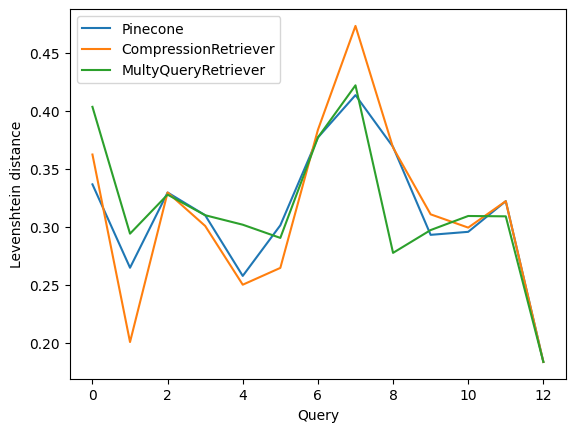

In [94]:
fig, ax = plt.subplots()
ax.plot(pinecone, label="Pinecone")
ax.plot(compression, label="CompressionRetriever")
ax.plot(multyquery, label="MultyQueryRetriever")
ax.set_ylabel("Levenshtein distance")
ax.set_xlabel("Query")
plt.legend()